# Explore here

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('/workspaces/temporary_series-RDH/data/raw/temporary_series_sales.csv', parse_dates = ['date'])
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [3]:
#revisión tipo de variables presentes en el dataSet
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [4]:
#Dimensiones de nuestro DataSet
df.shape

(366, 2)

In [5]:
#Revisión de datos faltantes:
df.isna().mean()*100

date     0.0
sales    0.0
dtype: float64

In [6]:
#Revisión de datos duplicados:
df.duplicated().sum()

np.int64(0)

In [7]:
#Revisión de valores únicos por columnas (valor único por dia):
df.nunique()

date     366
sales    366
dtype: int64

In [8]:
#Creamos nueva columna con valores de fechas sin horas, minutos y segundos:
df['date_days'] = df['date'].dt.date
df.head()

,date,sales,date_days
0,2022-09-03 17:10:08.079328,55.292157,2022-09-03
1,2022-09-04 17:10:08.079328,53.803211,2022-09-04
2,2022-09-05 17:10:08.079328,58.141693,2022-09-05
3,2022-09-06 17:10:08.079328,64.530899,2022-09-06
4,2022-09-07 17:10:08.079328,66.013633,2022-09-07


In [9]:
#Día de inicio del registro:
df['date_days'].min()

datetime.date(2022, 9, 3)

In [10]:
#Día final de la medición:
df['date_days'].max()

datetime.date(2023, 9, 3)

In [11]:
#Números de registros de fechas que coincidan con número de registros iniciales:
(df['date_days'].max() - df['date_days'].min()).days

365

In [12]:
#Creamos un nuevo df sin la columna de fechas con horas y minutos:
df_days = df.drop(columns = ['date'])
df_days.to_csv('/workspaces/temporary_series-RDH/data/interim/df_days.csv')

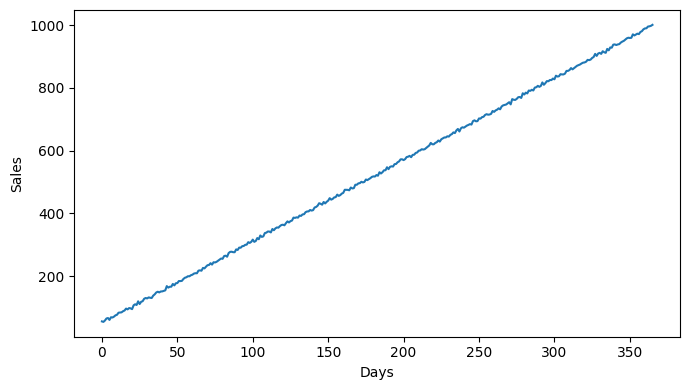

In [13]:
#Visualización de ventas por unidad de tiempo (dias):

fig, axis = plt.subplots(figsize = (7, 4))

sns.lineplot(x=df_days.index, y=df_days['sales'])
plt.tight_layout()
plt.xlabel('Days')
plt.ylabel('Sales')
plt.show()

In [14]:
#Ordenamos del df por fecha (antiguo a reciente):
df_days = df_days.sort_values('date_days')
df_days

,sales,date_days
0,55.292157,2022-09-03
1,53.803211,2022-09-04
2,58.141693,2022-09-05
3,64.530899,2022-09-06
4,66.013633,2022-09-07
...,...,...
361,989.600354,2023-08-30
362,994.987326,2023-08-31
363,995.814415,2023-09-01
364,997.350214,2023-09-02


### Análisis de la serie temporal (descomposición)

In [15]:
#Necesito convertir 'date_days' en un formato datetime

df_days['date_days'] = pd.to_datetime(df_days['date_days'])  # convertimos datetime.date a datetime64[ns]
df_days = df_days.set_index('date_days') #Indexamos fechas

### **Comentario**
El tensor mínimo para la cual existen datos, de acuerdo a lo visto, es día (24h). Es por eso que hemos eliminado las horas, minutos y segundos del registro. 

In [16]:
#Definición del método de descomposición
decomposition = seasonal_decompose(df_days['sales'], period = 30)
decomposition

## **Comentario**
He puesto un período mensual puesto que nuestros datos tienen el registro diario de un año exacto, pero entiendo que podríamos haber puesto una periodicidad semanal (7d) o anual (365d). 

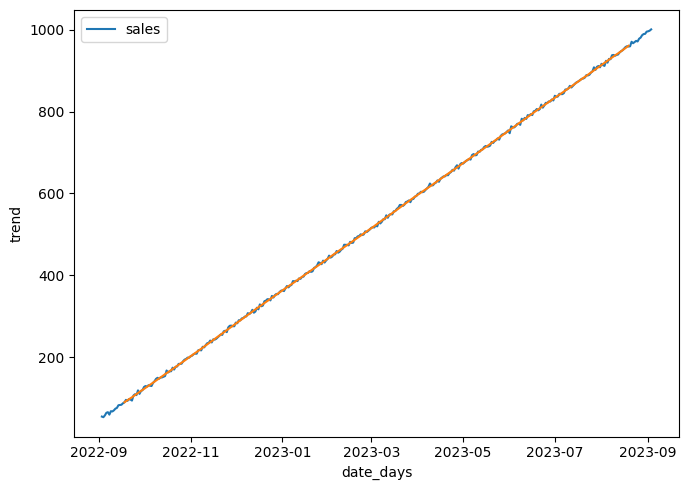

In [17]:
## Análisis de tendencia 
trend = decomposition.trend
fig, axis = plt.subplots(figsize = (7,5))

sns.lineplot(data = df_days)
sns.lineplot(data = trend)

plt.tight_layout()
plt.show()

## **Comentario**
No se ve con precisión el movimiento de la curva de tendencia sobre los datos en el tiempo, pero lo que si se aprecia es una tendencia positiva a lo largo del año. Las ventas aumentan con el tiempo de forma casi lineal.

Sin embargo, hacer los 3 gráficos por valor calculado de descomposición, no me permitirá ver ninguna variación dada la escala en la que se encuentra. Utlizaré el plt para decomposition. 

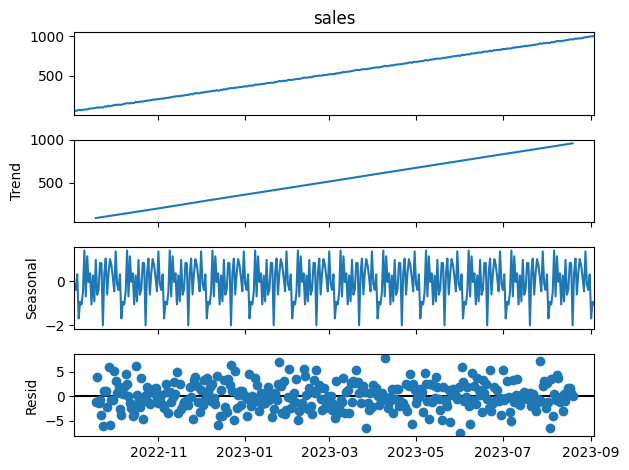

In [18]:
#Visualización de los tres valores de descomposición: Trend, Seasonal y Resid.
decomposition.plot()
plt.show()

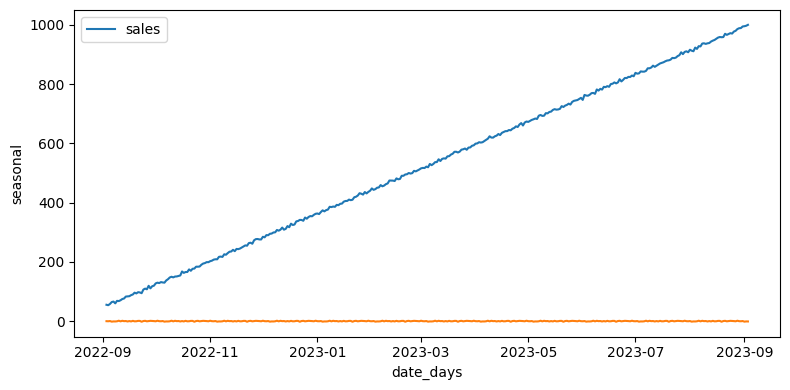

In [19]:
## Descomposición por temporada

seasonal = decomposition.seasonal
fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = df_days)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [20]:
## Aplicación de Dickey-Fuller para evaluar estadísticamente si nuestros datos constan de estacionaridad:

result = adfuller(df_days['sales'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("La serie es estacionaria")
else:
    print("La serie NO es estacionaria")

ADF Statistic: 0.545414193706378
p-value: 0.9861899815311064
La serie NO es estacionaria


### **Comentario**
En principio, teniendo una tendencia, por lo general, no debería ser estacionaria. Pero confirmamos con el estadístico de Dickey-Fuller para salir de dudas. Muestra una fluctuación de sus parámetros en el tiempo (con una tendencia creciente)

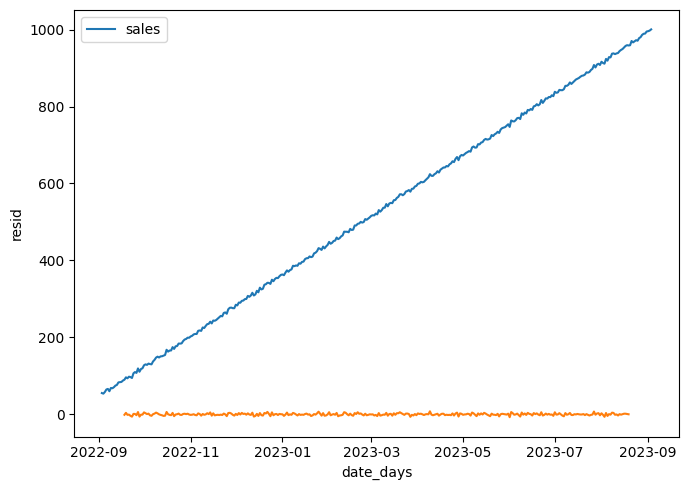

In [21]:
## Análisis de variabilidad (a través de los residuos - errores)

residual = decomposition.resid
fig, axis = plt.subplots(figsize = (7, 5))
sns.lineplot(data = df_days)
sns.lineplot(data = residual)
plt.tight_layout()
plt.show()

## **Comentario**
Con estos gráficos no puedo determinar si existe variabilidad y tampoco se puede ver cómo fluctúan los residuales en ellos. Haré un plot donde pueda mirar con más detalle y poder hacer alguna interpretación más acertada.

In [22]:
##Evaluación estadística de la estacionareidad del ruido (residuos)

result = adfuller(residual.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("Los residuales son estacionarios")
else:
    print("Los residuales NO son estacionarios")

ADF Statistic: -10.482643018173057
p-value: 1.2025891385804124e-18
Los residuales son estacionarios


## **OJO PARA REVISAR**

Si los residuales son estacionarios, quiere decir que:

La parte que queda después de quitar tendencia y estacionalidad no tiene patrones sistemáticos ni cambios en su media o varianza a lo largo del tiempo.

La variabilidad “inexplicada” es constante y aleatoria, sin tendencias ocultas ni ciclos.

Si no son estacionarios, quiere decir que:

Los residuales todavía tienen estructura o patrón temporal (por ejemplo, tendencia oculta, cambios en variabilidad) que el modelo de descomposición no logró eliminar.

Podría ser necesario otro tipo de análisis o transformación para capturar esa estructura residual.

In [23]:
# Consideración de diferenciación (serie NO estacionaria):
df_days['sales_diff'] = df_days['sales'].diff()
df_days.dropna(inplace=True)

### **Partición de Datos**

In [24]:
#Medición para los próximos meses (30d)
df_train = df_days.iloc[:-30]
df_test = df_days.iloc[-30:]

In [25]:
#Modelado con ARIMA: A pesar de haber hecho el cálculo diff, dejaremos que el modelo lo ejecute.

model = ARIMA(df_train['sales'], order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [28]:
#Obtención de métricas para evaluación de la predicción
mse = mean_squared_error(df_test['sales'], forecast)
mae = mean_absolute_error(df_test['sales'], forecast)
print(f"MSE: {mse}, MAE: {mae}")


MSE: 10.374430536200267, MAE: 2.6356565759330883


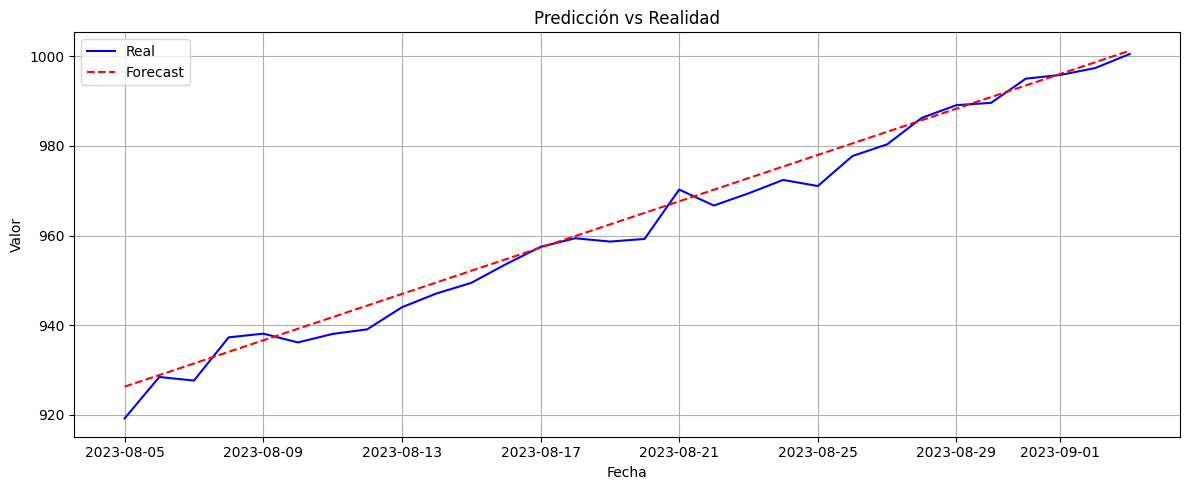

In [30]:
forecast = pd.Series(forecast, index=df_test.index)

plt.figure(figsize=(12, 5))
plt.plot(df_test['sales'], label='Real', color='blue')
plt.plot(forecast, label='Forecast', color='red', linestyle='--')
plt.title('Predicción vs Realidad')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()